In [53]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter
import h5py
import os
import pickle

In [54]:
data = np.load("/data/aram/Xenium/output-XETG00056__0004637__Region_1__20230718__204100/code/data/synthetic_data_2/gene_coordinates_test_cells1.npz")

# Access the arrays
x_coords = data['x_coords']
y_coords = data['y_coords']
gene_indices = data['gene_indices']

In [55]:
import pandas as pd

df = pd.DataFrame({
    'x_coords': x_coords,
    'y_coords': y_coords,
    'gene_indices': gene_indices
})

In [56]:
grid = np.zeros((100, 100))

for _, row in df.iterrows():
    x = row['x_coords']
    y = row['y_coords']
    gene_index = row['gene_indices']
    grid[y, x] = gene_index

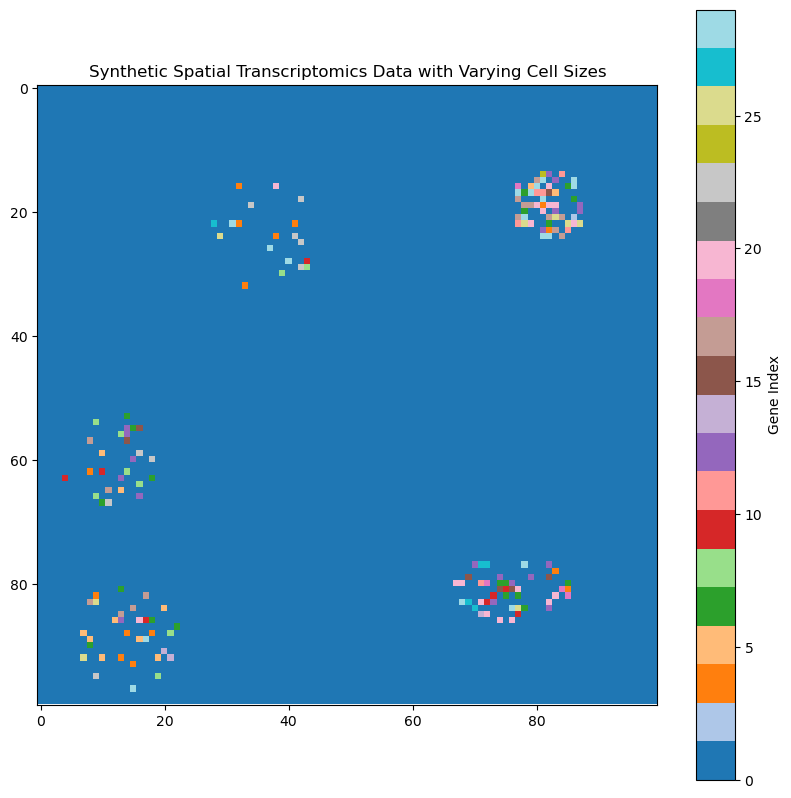

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Gene Index')
plt.title("Synthetic Spatial Transcriptomics Data with Varying Cell Sizes")
plt.show()

In [58]:
import torch
bounds = [((60,100), (60,100)),
          ((0,40), (20, 50)),
          ((0,30), (70,100)),
          ((77,100), (0,30)),
          ((40,75), (0,20))]

expression_vectors = []

for bound in bounds:
    y_bound, x_bound = bound
    
    filtered_df = df[(df['x_coords'] >= x_bound[0]) & (df['x_coords'] <= x_bound[1]) &
                     (df['y_coords'] >= y_bound[0]) & (df['y_coords'] <= y_bound[1])]
    
    expression_vector = [0] * 30
    expression_vector = torch.tensor(expression_vector, dtype=torch.float32)
    
    gene_counts = filtered_df['gene_indices'].value_counts()
    
    for gene_index, count in gene_counts.items():
        expression_vector[int(gene_index)] = count
    print(expression_vector.sum())
    expression_vectors.append(expression_vector)

tensor(45.)
tensor(21.)
tensor(54.)
tensor(34.)
tensor(26.)


In [59]:
expression_vectors

[tensor([0., 0., 0., 0., 2., 0., 0., 6., 0., 2., 2., 1., 2., 5., 1., 4., 0., 0.,
         3., 8., 1., 0., 0., 0., 0., 0., 1., 4., 0., 3.]),
 tensor([0., 2., 0., 2., 3., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 5., 0., 0., 1., 1., 0., 3.]),
 tensor([0., 0., 1., 0., 2., 2., 0., 5., 0., 0., 0., 5., 2., 4., 0., 1., 7., 2.,
         1., 5., 2., 0., 0., 0., 1., 2., 2., 0., 5., 5.]),
 tensor([0., 2., 0., 4., 1., 7., 1., 3., 2., 1., 0., 0., 1., 0., 2., 0., 4., 0.,
         0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 1.]),
 tensor([0., 0., 0., 0., 1., 2., 2., 2., 5., 1., 1., 0., 4., 1., 0., 2., 0., 2.,
         0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.])]

In [60]:
import torch.nn.functional as F

def compute_log_likelihood(expression_vector, cell_type_profile, umi_count):
    lambdas = umi_count * cell_type_profile
    # Compute Poisson log-likelihood: log P(v_i | λ_i)
    # Poisson log-likelihood: v_i * log(λ_i) - λ_i - log(v_i!)
    log_likelihood = expression_vector * torch.log(lambdas + 1e-8) - lambdas - torch.lgamma(expression_vector + 1)
    
    # Sum the log-probabilities across all genes to get the total log-likelihood
    total_log_likelihood = torch.sum(log_likelihood)
    
    average_log_likelihood = total_log_likelihood / umi_count
    
    return average_log_likelihood
    
    # return total_log_likelihood

def likelihood_model(expression_vector, temperature):
    """
    Takes in each row (cell) and computes a score.

    Args:
        expression_vector (torch.Tensor): Tensor of shape (n_genes,) representing gene counts for a cell.

    Returns:
        torch.Tensor: Scalar likelihood score for the cell.
    """
    observed_umi_count = torch.sum(expression_vector)

    log_likelihoods = torch.stack([
        compute_log_likelihood(expression_vector, cell_type_profile, observed_umi_count)
        for cell_type_profile in cell_type_profiles
    ])
    
    # return torch.max(log_likelihoods)
    prob = F.softmax(log_likelihoods/temperature, dim=0)
    print(log_likelihoods, "log_likelihoods")
    print(prob, "prob")
    max_index = torch.argmax(prob)
    max_value = prob[max_index]
    print(f"Cell type: {max_index.item()}, Prob: {max_value.item()}")
    # print(log_likelihoods, "log_likelihoods")
    print(prob*log_likelihoods, "prob*log_likelihoods")
    summed_likelihood = torch.sum(prob*log_likelihoods)
    # print(summed_likelihood, "summed_likelihood")
    return -summed_likelihood#torch.sum(prob * torch.log(prob + 1e-10), dim=0).mean()

In [61]:
with open("/data/aram/Xenium/output-XETG00056__0004637__Region_1__20230718__204100/code/data/synthetic_data_2/cell_type_profiles.pkl", 'rb') as f:
    cell_type_profiles_np = pickle.load(f)
    cell_type_profiles = torch.tensor(cell_type_profiles_np, dtype=torch.float32)

In [62]:
total = []
for expression_vector in expression_vectors:
    val = likelihood_model(expression_vector,0.01)
    total.append(val)

tensor([-2.0492, -2.6295, -1.8645, -2.2963, -2.1328, -1.8390, -2.9792, -2.0736,
        -1.8492, -2.1239, -2.6106, -1.5082, -1.8984, -2.8600, -0.8165, -2.4484,
        -1.6698, -2.0671, -1.9162, -1.7898]) log_likelihoods
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2039e-45,
        0.0000e+00, 0.0000e+00, 1.4013e-45, 0.0000e+00, 0.0000e+00, 9.0813e-31,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 8.7196e-38, 0.0000e+00,
        0.0000e+00, 5.3670e-43]) prob
Cell type: 14, Prob: 1.0
tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -8.4078e-45, -0.0000e+00, -0.0000e+00, -2.8026e-45, -0.0000e+00,
        -0.0000e+00, -1.3696e-30, -0.0000e+00, -0.0000e+00, -8.1647e-01,
        -0.0000e+00, -1.4560e-37, -0.0000e+00, -0.0000e+00, -9.5989e-43]) prob*log_likelihoods
tensor([-2.5563, -2.3662, -1.3659, -2.9119, -2.8103, -2.2396, -1.6116, -2.3635,
        -1.7731, -2.4763, -2.3654, -2.6913, -2.5288, -2.8322, -2.3333, -2.5449,
  

In [69]:
total

[tensor(0.8165),
 tensor(1.3659),
 tensor(0.8066),
 tensor(0.9780),
 tensor(1.1110)]

In [63]:
sum(total)

tensor(5.0778)

In [64]:
def pairwise_distance_loss(df):
    """
    Calculate the differentiable pairwise distance loss based on height and width coordinates.
    
    Args:
        height_coords (torch.Tensor): Tensor of shape (n_samples,) containing standardized height coordinates.
        width_coords (torch.Tensor): Tensor of shape (n_samples,) containing standardized width coordinates.
        output_matrix (torch.Tensor): Tensor of shape (n_samples, 5) representing the softmax output from the model.

    Returns:
        torch.Tensor: The computed pairwise distance loss (scalar).
    """
    coords = torch.tensor(df[['x_coords', 'y_coords']].values, dtype=torch.float32)
    
    # Compute pairwise distances
    pairwise_distances = torch.cdist(coords, coords)
    # Calculate total loss by summing all pairwise distances
    total_loss = pairwise_distances.sum()
    
    # Normalize the loss by the number of samples squared
    n_samples = coords.size(0)
    normalized_loss = total_loss / (n_samples)
    
    return normalized_loss


pair_total = []  

for bound in bounds:
    y_bound, x_bound = bound
    
    filtered_df = df[(df['x_coords'] >= x_bound[0]) & (df['x_coords'] <= x_bound[1]) &
                     (df['y_coords'] >= y_bound[0]) & (df['y_coords'] <= y_bound[1])]
    
    pair_total.append(pairwise_distance_loss(filtered_df))
    


In [65]:
pair_total

[tensor(311.5698),
 tensor(175.2585),
 tensor(282.9459),
 tensor(257.5447),
 tensor(178.6169)]

In [68]:
sum(pair_total)

tensor(1205.9357)

In [67]:
import math

def softmax(lst, temperature=1.0):
    exp_list = [math.exp(i / temperature) for i in lst]  # Adjust each element by the temperature
    sum_exp = sum(exp_list)  # Sum of all exponentiated values
    return [j / sum_exp for j in exp_list]  # Divide each exponentiated value by the sum

